In [1]:
import random

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from IPython.display import display, Math, Latex

In [3]:
class Strategy:
    
    def __init__(self, n_arms: int):
        self.n_arms = n_arms
        self.n_iters = 0
        self.arms_states = np.zeros(n_arms)
        self.arms_actions = np.zeros(n_arms)
        
    def flush(self):
        self.n_iters = 0
        self.arms_states = np.zeros(self.n_arms)
        self.arms_actions = np.zeros(self.n_arms)
        
    def update_reward(self, arm: int, reward: int):
        self.n_iters += 1
        self.arms_states[arm] += reward
        self.arms_actions[arm] += 1
        
    def choose_arm(self):
        raise NotImplementedError

In [4]:
class EpsGreedy(Strategy):
    
    def __init__(self, n_arms: int, eps: float = 0.1):
        super().__init__(n_arms)
        self.eps = eps
        
    def choose_arm(self):
        if random.random() < self.eps:
            return random.randint(0, self.n_arms - 1) # choose random arm
        else:
            return np.argmax(self.arms_states / self.arms_actions) # choose the best arm

In [5]:
class UCB1(Strategy):
    
    def choose_arm(self):
        if self.n_iters < self.n_arms:
            return self.n_iters
        else:
            return np.argmax(self.ucb())

    def ucb(self):
        ucb = self.arms_states / self.arms_actions # mean x_j
        ucb += np.sqrt(2 * np.log(self.n_iters) / self.arms_actions) # confidence part
        return ucb

In [7]:
class Thompson(Strategy):
    
    def __init__(self, n_arms: int):
        super().__init__(n_arms)
        self.alpha = np.ones(n_arms)
        self.beta = np.ones(n_arms)
        
    def update_reward(self, arm: int, reward: int):
        super().update_reward(arm, reward)
        if reward > 0:
            self.alpha[arm] += 1
        else:
            self.beta[arm] += 1
        
    def choose_arm(self):
        prior_values = np.random.beta(self.alpha, self.beta)
        return np.argmax(prior_values)

In [8]:
class BernoulliEnv:
    
    def __init__(self, arms_proba: list):
        self.arms_proba = arms_proba
        
    @property
    def n_arms(self):
        return len(self.arms_proba)
        
    def pull_arm(self, arm_id: int):
        if random.random() < self.arms_proba[arm_id]:
            return 1
        else:
            return 0 

In [9]:
class Bandit:
    
    def __init__(self, env: BernoulliEnv, strategy: Strategy):
        self.env = env
        self.strategy = strategy
        
    def action(self):
        arm = self.strategy.choose_arm()
        reward = self.env.pull_arm(arm)
        self.strategy.update_reward(arm, reward)

In [10]:
def calculate_regret(env: BernoulliEnv, strategy: Strategy, n_iters=2000):
    strategy.flush()
    bandit = Bandit(env, strategy)
    regrets = []
    for i in range(n_iters):
        reward = bandit.strategy.arms_actions.dot(env.arms_proba)
        optimal_reward = np.max(env.arms_proba) * i
        regret = optimal_reward - reward
        regrets.append(regret)
        bandit.action()
        
    return regrets

In [11]:
be = BernoulliEnv([0.3, 0.5, 0.7])
eps_1 = EpsGreedy(be.n_arms, 0.1)
eps_2 = EpsGreedy(be.n_arms, 0.3)
eps_3 = EpsGreedy(be.n_arms, 0.5)
ucb = UCB1(be.n_arms)
tompson = Thompson(be.n_arms)

И посчитаем для каждый их этих стратегий $\mathrm{regret}$-ы

In [12]:
# Calculate regrets
eps_regrets = calculate_regret(be, eps_1)
eps_2_regrets = calculate_regret(be, eps_2)
eps_3_regrets = calculate_regret(be, eps_3)
ucb_regrets = calculate_regret(be, ucb)
tompson_regrets = calculate_regret(be,tompson)

/home/nur/projects/analysis/env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Теперь давайте построим график неколько $\mathrm{regret}$-ов (чем ниже, тем лучше)

Text(0, 0.5, 'cumulative regret (less is better)')

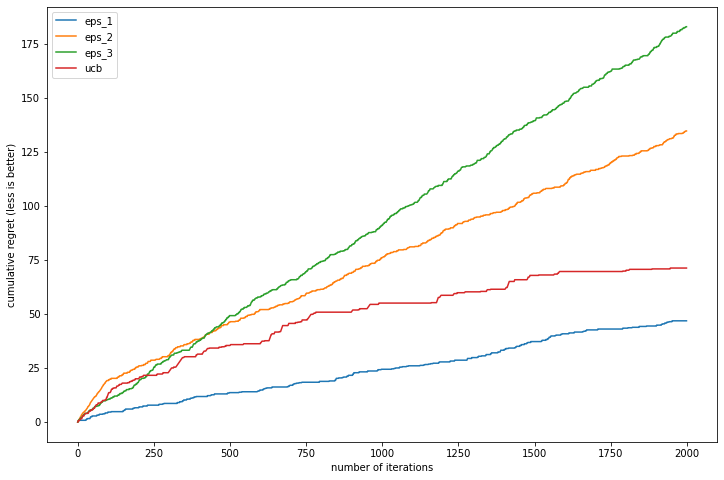

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(eps_regrets, label='eps_1')
plt.plot(eps_2_regrets, label='eps_2')
plt.plot(eps_3_regrets, label='eps_3')
plt.plot(ucb_regrets, label='ucb')
plt.legend()
plt.xlabel('number of iterations')
plt.ylabel('cumulative regret (less is better)')

# Contextual bandits

In [28]:
from space_bandits.toy_problem import get_cust_reward, get_customer, get_rewards

В данном случаем мы работаем с 2-мя группами клиентов. Каждый клиент описывается 2-мя характеристиками: H, ARPU

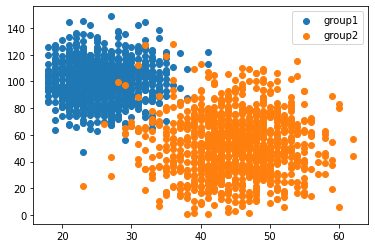

In [16]:
group1 = [get_customer(ctype=1)[1] for x in range(1000)]
group2 = [get_customer(ctype=2)[1] for x in range(1000)]
plt.scatter([x[0] for x in group1], [x[1] for x in group1], label='group1')
plt.scatter([x[0] for x in group2], [x[1] for x in group2], label='group2')
plt.legend()

У нас есть клиенты (`cutomers`) и награды (`rewards`) которые представляют собой вектор из 3 возможных значений. По сути это 3 акции, которая компания может предложить. Первая - лучше всего подходит первой группе, третья лучше всего подходит второй группе, а вторая акция не является оптимально ни для одной из 2х групп. 

Контекстуальные бандиты очень изящно обрабатывают такое поведение, так как они моделуют генерацию вознагражения как случайный процесс.

Чтобы убедиться, что генерация вознаграждений работает правильно, давайте посчитаем среднее вознаграждение для каждой из групп.

In [29]:
for ctype in range(1,3):
    customers = [get_customer(ctype=ctype) for x in range(100000)]
    rewards = np.concatenate([np.expand_dims(get_rewards(cust), axis=0) for cust in customers])
    print(f'group {ctype} expected rewards: (100000 samples)', rewards.mean(axis=0))

group 1 expected rewards: (100000 samples) [9.0004  2.49625 1.999  ]
group 2 expected rewards: (100000 samples) [ 2.5005   2.48975 20.037  ]


Если мы подумаем об этом в рамках проблемы о динмическом ценообразованиее, то можно представить следующее: пусть имеются группы покупателей, который пришли на сайт, чтобы купить опеределнный `SKU`. Мы не знаем количества групп, не знаем их точного распределения, и не знаем какой покупатель какой группе принадлежит, но хотели бы это установить в будущем. Однако у нас есть некоторые описательные характеристики для пользоваелей в виде, например, среднего чека за покупку или среднее количество `SKU`, которое они купили за последнюю покупку итд. Затем для каждого покупателя мы можем предложить несколько моделей, будем случайно выбирать модель, брать предсказание выданное для пользователя, ставить предложенную моделью цену и смотреть награду за нее в виде либо купил/не купил или значение по какой цене покупатель в итоге купил товар. По сути мы можем выбрать такие модели, которые будут хорошо работать на определенных группах покупателей.

Посмотрим на наших сгенерированных покупателей `customers`

In [30]:
customers[:10]

[(2, (41, 44.35311627409041)),
 (2, (47, 62.80183870501591)),
 (2, (44, 35.37987906318664)),
 (2, (41, 77.19624306317507)),
 (2, (47, 64.68531064399968)),
 (2, (51, 16.07013344272721)),
 (2, (41, 58.8039929537227)),
 (2, (39, 37.173769327042635)),
 (2, (47, 51.63417767643129)),
 (2, (47, 40.25507969256374))]

Ну и посмотрим на награды `rewards`

In [19]:
rewards

array([[ 0,  0,  0],
       [10,  0,  0],
       [ 0,  0,  0],
       ...,
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0]])

На первом проходе мы будем использовать Байесовскую модель линейной регресси, которая напрямую сопоставляет функцию с ожидаемым вознаграждением с помощью линейных коеффициентов. По сути мы будем использовать онлайн-обучение: модель принимает решение - выбирает action (ручку), получает вознаграждение и затем делает это заново

Мы будем использовать линейную модель `LinearBandits` из `space_bandits`

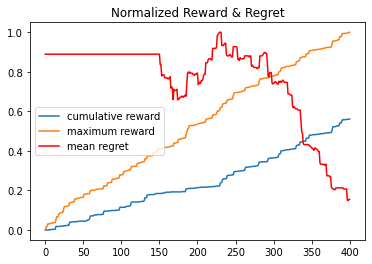

In [32]:
from space_bandits import LinearBandits
 
num_actions = 3 # num of available models (promo strategies)
num_features = 2 # num of features per customer

linear_model = LinearBandits(num_actions, num_features, initial_pulls=100)
optimal_choices = [None, 0, 2]

def iterate_model(model, optimal_choices, steps, records=None, plot_frequency=250, avg_length=150):
    """Goes through online learning simulation with model."""
    #these will track values for plotting
    if records is None:
        records = dict()
        records['timesteps'] = []
        records['c_reward'] = []
        records['cumulative_reward'] = 0
        records['m_reward'] = []
        records['maximum_reward'] = 0
        records['regret_record'] = []
        records['avg_regret'] = []
        start = 0
    else:
        start = records['timesteps'][-1]
    for i in range(start, start+steps):
        records['timesteps'].append(i)
        #generate a customer
        cust = get_customer()
        
        #generate customer decisions based on group
        reward_vec = get_rewards(cust)
        
        #prepare features for model
        context = np.array([cust[1]])
        best_choice = optimal_choices[cust[0]]
        
        #get reward for 'best' choice
        mx = reward_vec[best_choice]
        records['maximum_reward'] += mx
        records['m_reward'].append(records['maximum_reward'])
        
        # make and action
        action = model.action(context)
        
        #get reward for the action chosen by model
        reward = reward_vec[action]
        
        #regret is the opportunity cost of not choosing the optimal promotion
        regret = mx - reward
        records['regret_record'].append(regret)
        records['cumulative_reward'] += reward
        records['c_reward'].append(records['cumulative_reward'])
        model.update(context, action, reward)
        
        #plot occasionally
        if i <= avg_length:
            if i < avg_length:
                moving_avg=0
            else:
                moving_avg = np.array(records['regret_record']).mean()
            if i == avg_length:
                records['avg_regret'] = [moving_avg] * avg_length
        else:
            moving_avg = sum(records['regret_record'][-avg_length:])/avg_length
        records['avg_regret'].append(moving_avg)
        if i % plot_frequency == 0 and i > 0:
            c_rewardplt = np.array(records['c_reward'])/max(records['m_reward'])
            m_rewardplt = np.array(records['m_reward'])/max(records['m_reward'])
            regretplt = np.array(records['avg_regret'])/max(records['avg_regret'])
            plt.plot(records['timesteps'], c_rewardplt, label='cumulative reward')
            plt.plot(records['timesteps'], m_rewardplt, label='maximum reward')
            plt.plot(records['timesteps'], regretplt, color='red', label='mean regret')
            plt.title('Normalized Reward & Regret')
            plt.legend()
            plt.show()
    return records
            
records = iterate_model(linear_model, optimal_choices, 401, plot_frequency=400)


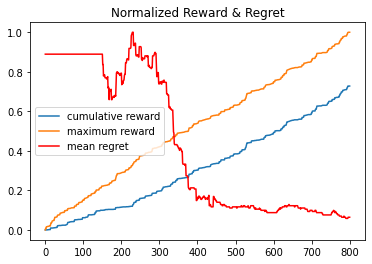

In [34]:
# from space_bandits import load_model
# linear_model.save('test_path.pkl')
# linear_model = load_model('test_path.pkl')

#continue training

records = iterate_model(linear_model, optimal_choices, 401, plot_frequency=800, records=records)

Давайте теперь для модели построим разделяющую прямую, которая делит 2 облака покупателей, на основании моделирования

/home/nur/projects/analysis/env/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


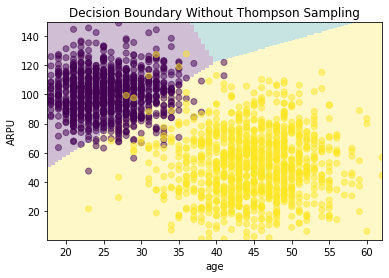

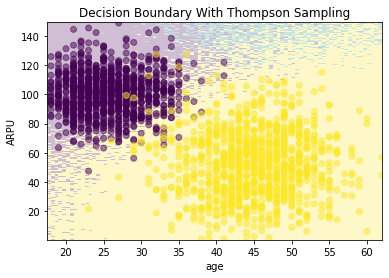

took  2.52  seconds.


In [22]:
def plot_decision_boundary(model, X, Y, h=1, scale=1., parallelize=True, title='decision boundary', thompson=False, classic=False, n_threads=-1, flip_colors=True):
    ftnames = X.columns[0], X.columns[1]
    X = X.values
    #model.fit(X[:, :2], Y)
    x_min = X[:, 1].min() - .5
    x_max = X[:, 1].max() + .5
    y_min = X[:, 0].min() - .5
    y_max = X[:, 0].max() + .5
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    if classic:
        Z = model.classic_predict(np.c_[xx.ravel(), yy.ravel()]/scale, thompson=thompson)
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()]/scale, thompson=thompson, parallelize=parallelize)

    # Put the result into a color plot.
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, alpha=.25)

    # Add the training points to the plot.
    if flip_colors:
        Y = np.where(np.array(Y)==1, 0, 1)
    plt.scatter(X[:, 1], X[:, 0], c=Y, alpha=.5);
    #plt.scatter(X[:, 1], X[:, 0], c='black', alpha=.1);


    plt.xlabel(ftnames[1])
    plt.ylabel(ftnames[0])

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max());
    plt.title(title)
    plt.show()
    
    
from time import time
X = group1 + group2
Y = [1 for x in range(1000)] + [0 for x in range(1000)]
ages = [x[0] for x in X]
ARPUs = [x[1] for x in X]
as_df = pd.DataFrame()
as_df['ARPU'] = ARPUs
as_df['age'] = ages
X = as_df



plot_decision_boundary(linear_model, X, Y, h=.5, thompson=False, title='Decision Boundary Without Thompson Sampling')

t1 = time()
plot_decision_boundary(linear_model, X, Y, h=.5, thompson=True, parallelize=True, n_threads=3, title='Decision Boundary With Thompson Sampling')
print('took ', round(time()-t1, 2), ' seconds.')

Видно, что с семлированием Томпсона граница несколько размыта (эффект градиента). Это связано с тем, что в тех регионах, где уверенности у модели нет, например, где группы клиентов пересекаются, семплирование Томпсона возвращает сочетание рекомендаций между 2-мя вариантами, и это позволяет оптимизировать модель с помощью будущих примеров. Таким образом семплирование Томпсона дает "умный" способ исследования.

Есть один интересный момент: в регионах где нет или очень мало покупателей (сэмплов) модель может рекоммендовать плохую рекламу (2 стратегия) так как она не знает, что для того региона эта модель не походит

Давайте теперь посмотрим на Бандитов, моделирующих награду с помощью нейронной сети `NeuralBandits`

Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...


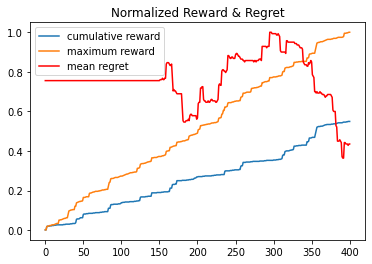

In [23]:
from space_bandits import NeuralBandits

num_actions = 3
num_features = 2
memory_size = 10000

neural_model = NeuralBandits(num_actions, num_features, initial_pulls=100, memory_size=memory_size, layer_sizes=[50, 12])
assert neural_model.data_h.memory_size == memory_size

records = iterate_model(neural_model, optimal_choices, 401, plot_frequency=400)

In [24]:
records = iterate_model(neural_model, optimal_choices, 401, plot_frequency=800)

Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...


/home/nur/projects/analysis/env/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


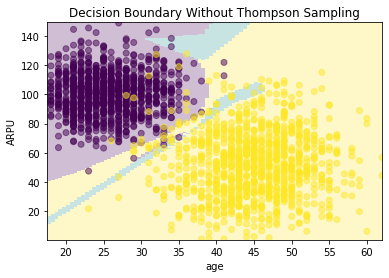

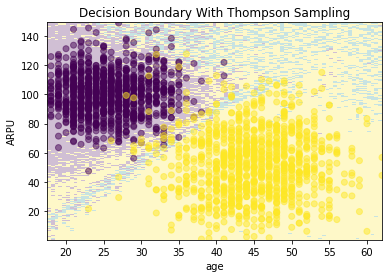

took  3.1996467113494873


In [25]:
plot_decision_boundary(neural_model, X, Y, h=.5, thompson=False, title='Decision Boundary Without Thompson Sampling', n_threads=3)


t1 = time()
plot_decision_boundary(neural_model, X, Y, h=.5, thompson=True, parallelize=True, title='Decision Boundary With Thompson Sampling', n_threads=3)
print('took ', time() - t1)

Как раз на картинке виден тот эффект "рекоммендации плохой для всех стратегии"

Есть еще одна библиотека для работы с контекстуальными бандитами

В целом она тоже очень популярная, но единственное ограничение это то, что награда может моделироваться только как дискретная и принимать значение только {0,1}. В целом такая библиотека тоже может быть полезной для динамического ценообразования.

In [36]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file

def parse_data(filename):
    with open(filename, "rb") as f:
        infoline = f.readline()
        infoline = re.sub(r"^b'", "", str(infoline))
        n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
        features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    features = np.array(features.todense())
    features = np.ascontiguousarray(features)
    return features, labels

X, y = parse_data("/home/nur/projects/analysis/dynamic_price/data/context_bandits/Bibtex_data.txt")
print(X.shape)
print(y.shape)

(7395, 1836)
(7395, 159)


In [ ]:
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, LogisticUCB, \
            SeparateClassifiers, EpsilonGreedy, AdaptiveGreedy, ExploreFirst, \
            ActiveExplorer, SoftmaxExplorer
from copy import deepcopy